In [27]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torchvision.io import read_image
from fastai.vision.all import *
from natsort import natsorted
import gc
import scipy.io
from tqdm import tqdm
from utils import *
from fsl_utils import *
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

clear_gpu_cache()

## easyfsl library for few-shot learning
from torchvision.models import resnet18
from easyfsl.samplers import TaskSampler
from easyfsl.modules import resnet12
from easyfsl.utils import plot_images, sliding_average
from statistics import mean
import copy

cuda


Let's implement 10-shot learning because for each class we have 10 images.

This is not a strict 10-shot learning because we are training on all 102 classes and also testing on the same 102 classes. Typically, to evaluate the performance of k-shot learning, we keep few classes unseen in the training dataset. But let's just ignore it.

__Episodic Training : Meta-learning__

In [28]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [29]:
# load dataset

split = scipy.io.loadmat('official_data/setid.mat')

# Subtract 1 to make index start from 0
train_inds = split['trnid'].flatten() - 1 
val_inds = split['valid'].flatten() - 1
test_inds = split['tstid'].flatten() - 1

print('Min indexes: ', train_inds.min(), val_inds.min(), test_inds.min())
print('Max indexes: ', train_inds.max(), val_inds.max(), test_inds.max())
print('   Size    : ', train_inds.shape[0], val_inds.shape[0], test_inds.shape[0])

labels_file = scipy.io.loadmat('official_data/imagelabels.mat')
labels = labels_file['labels']
labels = labels.flatten() - 1  # to make it start from 0 to 101
print('labels shape', labels.shape)
print('First class index: ', labels.min(), ' Last class index: ', labels.max())


train_labels = torch.from_numpy(labels[train_inds]); print(len(train_labels), 'train labels: ', train_labels)
val_labels = torch.from_numpy(labels[val_inds]); print(len(val_labels), 'val labels: ', val_labels)
test_labels = torch.from_numpy(labels[test_inds]); print(len(test_labels), 'test labels: ', test_labels)

all_files = get_image_files('official_data/102flowers/jpg/')
train_files = all_files[train_inds]; print('train_files: ', len(train_files))
val_files = all_files[val_inds]; print('val_files: ', len(val_files))
test_files = all_files[test_inds]; print('test_files: ', len(test_files))

Min indexes:  27 16 0
Max indexes:  8176 8186 8188
   Size    :  1020 1020 6149
labels shape (8189,)
First class index:  0  Last class index:  101
1020 train labels:  tensor([  0,   0,   0,  ..., 101, 101, 101], dtype=torch.uint8)
1020 val labels:  tensor([  0,   0,   0,  ..., 101, 101, 101], dtype=torch.uint8)
6149 test labels:  tensor([  0,   0,   0,  ..., 101, 101, 101], dtype=torch.uint8)
train_files:  1020
val_files:  1020
test_files:  6149


In [30]:
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop((224, 224), scale = (0.7, 1.0), ratio = (0.85, 1.15)),
#     transforms.RandomHorizontalFlip(p=0.3),
#     transforms.RandomVerticalFlip(p=0.3),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

`FlowerDataset_fsl` below is a very flexible `Dataset` class that I created. It allows augmentations, if we want. But if we don't want them, we can just keep `num_augmentations=1` and `transform=test_transform` for all of the `train_ds`, `val_ds` and `test_ds`.

In [31]:
train_ds = fsl_dataset(train_files, train_labels, num_augmentations=1, transform=test_transform)
val_ds = fsl_dataset(val_files, val_labels, num_augmentations=1, transform=test_transform)
test_ds = fsl_dataset(test_files, test_labels, num_augmentations=1, transform=test_transform) 

Example:
    
`n_way` = 10 # let's include only 10 classes out of N classes at once in a single episode or minibatch
`n_shot` = 7 # Let's use 7 out of 20 for tranining in single episode
`n_query` = 3 # Let's use 3 out of remaining 10 as query in single episode

Training episode:
- Support set: 10 classes * 7 examples per class = 70 images in single episode
- Query set: 10 classes * 3 examples per class = 30 images in single episode



Validation episode:
- For each validation episode, the model is evaluated on how well it generalizes from 70 support images to 30 query imags in single episode.


In [41]:
train_sampler = TaskSampler(
    train_ds, n_way=5, n_shot=7, n_query=3, n_tasks=200
)
val_sampler = TaskSampler(
    val_ds, n_way=5, n_shot=7, n_query=3, n_tasks=200
)

test_sampler = TaskSampler(
    test_ds, n_way=5, n_shot=7, n_query=3, n_tasks=200
)

# Finally, the DataLoader. It has a customized collate_fn so that batches are delivered
# in the shape: (support_images, support_labels, query_images, query_labels, class_ids)
train_loader = DataLoader(
    train_ds,
    batch_sampler=train_sampler,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)


val_loader = DataLoader(
    val_ds,
    batch_sampler=val_sampler,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)


test_loader = DataLoader(
    test_ds,
    batch_sampler=test_sampler,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


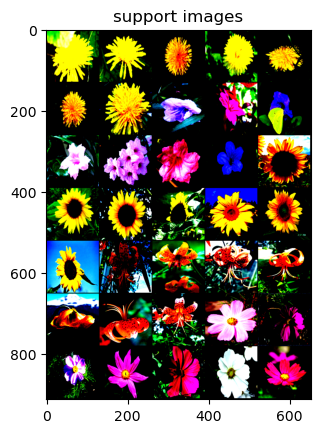

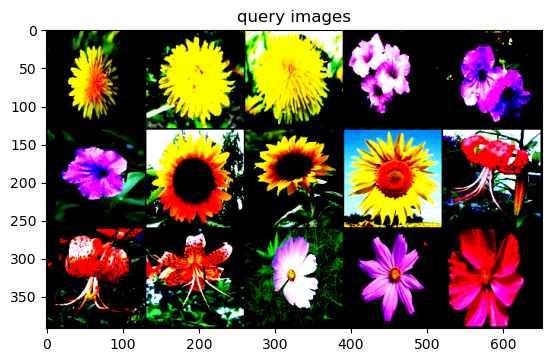

In [33]:
example_support_images, example_support_labels, example_query_images, example_query_labels, example_class_ids = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=5)
plot_images(example_query_images, "query images", images_per_row=5)

# Performance of untrained resnet18 - Prototypical Network

In [34]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )

In [35]:
# convolutional_network = resnet12()
# few_shot_classifier = PrototypicalNetworks(convolutional_network).to(device)

convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()

model = PrototypicalNetworks(convolutional_network).to(device)

C:\Users\mgupta70.ASURITE\.conda\envs\kerastens\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mgupta70.ASURITE\.conda\envs\kerastens\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
# performance on sample test batch
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{example_class_ids[example_query_labels[i]]} / {example_class_ids[example_predicted_labels[i]]}"
    )

Ground Truth / Predicted
49 / 49
49 / 49
49 / 49
97 / 97
97 / 97
97 / 97
53 / 53
53 / 49
53 / 53
5 / 5
5 / 5
5 / 5
33 / 33
33 / 33
33 / 33


In [37]:
evaluate(test_loader)

100%|██████████| 200/200 [01:23<00:00,  2.39it/s]

Model tested on 200 tasks. Accuracy: 90.83%


So, the untrained Resnet18 has 5-way 5-shot accuracy of 88.56% on test set

In [38]:
def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))
            
  

100%|██████████| 200/200 [01:29<00:00,  2.23it/s, loss=0.191]


In [43]:
evaluate(test_loader)

100%|██████████| 200/200 [01:25<00:00,  2.35it/s]

Model tested on 200 tasks. Accuracy: 80.60%


For some reason, after training for 200 minibatches (or episodes), the 5-way-5shot and 5-way-7-shot performance reduced is reducing. Maybe we are tuning a large number of params with a small dataset. We could experiment with freezing some layers and only train the head. Performance can also be related to scaling laws or rightly setting hyperparameters or image types.

    Results:    pretrained vs fine-tuning
  1. 5-way 5-shot = 88.56% vs 82.2%
  2. 5-way 7-shot = 90.83% vs 80.6%